# 차선 검출 알고리즘

**본 코드는 colab에서 실행되었습니다.**



## 1. Gitclone & exploration  
코드를 구현하기에 앞서 gitclone을 진행하고 임의의 이미지를 이용하여 작성된 차선검출 알고리즘을 실험합니다. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/차량지능기초"

/content/drive/My Drive/차량지능기초


In [ ]:
!git clone https://github.com/Lhyejin/LaneNet-PyTorch.git

fatal: destination path 'LaneNet-PyTorch' already exists and is not an empty directory.


In [ ]:
%cd LaneNet-PyTorch//
!ls
!pip install -r requirements.txt

/content/drive/My Drive/차량지능기초/LaneNet-PyTorch
dataset  LICENSE	      requirements.txt	Train.ipynb
img	 Notebook-experiment  test.py		TUSIMPLE
Lanenet  README.md	      Train_aug.ipynb	utils


In [ ]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
import os
import matplotlib.pylab as plt
import sys
from tqdm import tqdm
import imageio
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet
from utils.evaluation import gray_to_rgb_emb, process_instance_embedding
from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the Model
model_path = './TUSIMPLE/Lanenet_output/lanenet_epoch_39_batch_8.model'
LaneNet_model = Lanenet(2, 4)
LaneNet_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
LaneNet_model.to(device)

def inference(gt_img_org):
    # BGR 순서
    org_shape = gt_img_org.shape
    gt_image = cv2.resize(gt_img_org, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
    gt_image = gt_image / 127.5 - 1.0
    gt_image = torch.tensor(gt_image, dtype=torch.float)
    gt_image = np.transpose(gt_image, (2, 0, 1))
    gt_image = gt_image.to(device)
    # lane segmentation 
    binary_final_logits, instance_embedding = LaneNet_model(gt_image.unsqueeze(0))
    binary_final_logits, instance_embedding = binary_final_logits.to('cpu'), instance_embedding.to('cpu') 
    binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()
    binary_img[0:65,:] = 0

    # lane clustering & segemented frame embedding
    rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img,
                                                          distance=1.5, lane_num=4)

    rbg_emb = cv2.resize(rbg_emb, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_LINEAR)
    a = 0.6
    frame = a * gt_img_org[..., ::-1] / 255 + rbg_emb * (1 - a)
    frame = np.rint(frame * 255)
    frame = frame.astype(np.uint8)

    return frame



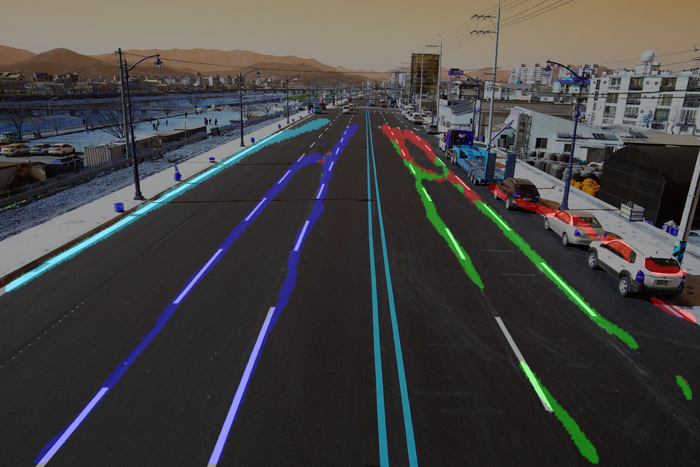

In [ ]:
image = cv2.imread('../dataset/123.jpg')
cv2_imshow(inference(image))

## 수행코드 작성 및 함수화 

 위의 단계에서 본 알고리즘이 정상적으로 작동하는 것을 확인하였으니 영상을 기반으로 하는 알고리즘을 작성합니다. 
 

In [ ]:
import cv2
vidcap = cv2.VideoCapture('../dataset/video.mp4')
pathOut = '../dataset/output.mp4'
frames_array=[]

fps = 25

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        frames_array.append(image)
        height, width, layers = image.shape
        size = (width,height)
    
    return hasFrames
sec = 0
frameRate = 0.04 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)



out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, (1920,1080))
for i in range(len(frames_array)):
    frames_array[i]=inference(frames_array[i])
    out.write(frames_array[i])
out.release()

## 함수화 

위 단계에서 영상을 입력으로 frame으로 분할한 뒤, 각각의 frame에 inference함수(차선 검출 알고리즘)을 적용하여 frame들을 다시 video형태로(segmented 된) 합치는 것을 확인 하였습니다.
이 코드를 정리하여 함수화 합니다. 


In [ ]:

def video2segemented_video(video_path):
    # TODO: video to frames
    vidcap = cv2.VideoCapture(video_path)
    pathOut = '../dataset/output.mp4'
    frames_array=[]

    fps = 25

    def getFrame(sec):
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            frames_array.append(image)
            height, width, layers = image.shape
            size = (width,height)
        
        return hasFrames
    sec = 0
    frameRate = 0.04 #//it will capture image in each 0.5 second
    count=1
    success = getFrame(sec)
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success = getFrame(sec)

    # TODO: extract lane from frame & frames to video & store video

    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, (1920,1080))
    for i in range(len(frames_array)):
        frames_array[i]=inference(frames_array[i])
        out.write(frames_array[i])
    out.release()

    pass

In [ ]:
import cv2
video2segemented_video('../dataset/video.mp4')

## output

 아래 이미지는 output으로 나온 이미지의 캡처본입니다.   
보시는 것과 같이 차선 영역(빨간 박스)은 차선을 올바르게 검출하는 반면 하늘 영역(하얀 박스)에도 차선이라고 판단하여 표시되는 것이 있습니다. 


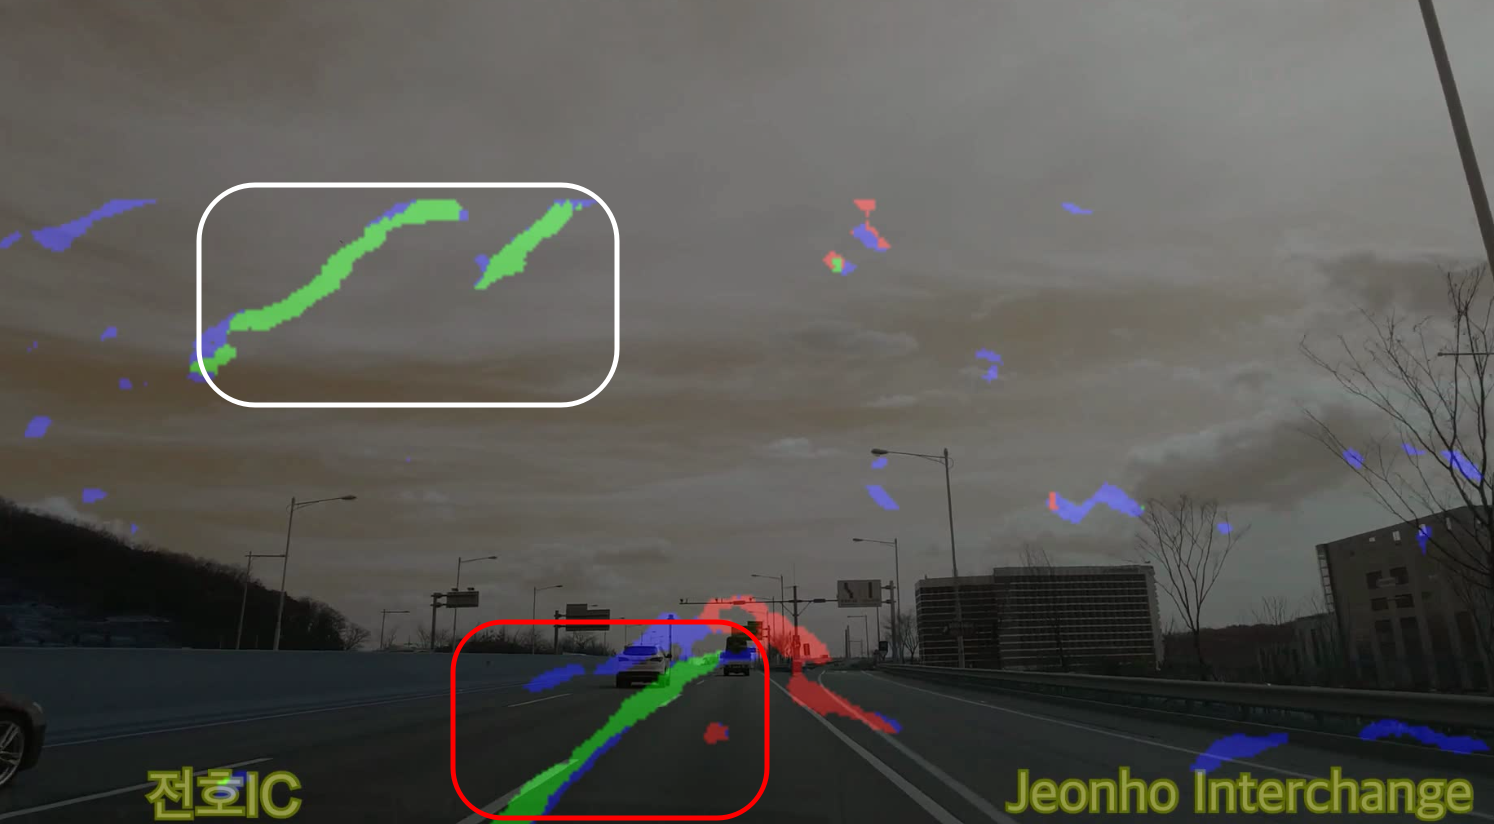



## 결과 video (output) 

위 함수를 이용하여 도출된 video는 제 깃허브에 첨부되어 있습니다. 

## 부가 설명 

위 코드에 이용한 영상 데이터는 youtube에서 parsig하여 구한 영상 입니다. 
 (출처 : https://www.youtube.com/watch?v=Mfk4qWVimBw&t=766s)
 
영상의 분할은 25fps로 진행하였으며 다시 video로 합치는 과정도 25fps로 하여 영상이 부드럽게 재생되도록 하였습니다. 

## 고찰 

제시해 주신 알고리즘을 이용하여 임의의 이미지를 실험하였을 때, 깔끔하게 차선만 도출한 결과를 내지 못한 것을 확인하였습니다. 
어떠한 이유인지 정확히 알 수 없지만 input이미지가 깔끔한 이미지가 아니기 때문이라 생각이 듭니다. 

또한 제가 구현한 함수(차선 검출 코드)를 이용하여 video를 input으로 output video를 도출 하였을 때, 이 또한 깔끔하지 않은 것을 확인 할 수 있습니다. 이는 입력에 사용한 데이터를 parsing하여 구한것 때문이거나 video를 frame으로 분할하고 다시 합치는 과정에 data에 영향이 있었다고 추측합니다. 이에 대해서 정확히 어떠한 이유 때문인지 찾아볼 예정입니다. 


